# Author: Jirath Thanabarameth and Kittipot Chumwuttiluck
# Course: DES432 Statistics and Data Modeling
# Project 1: Exploratory Data Analysis & Inference

# 1. Data Loading

**Import Library**

In [26]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

 **Load Dataset**

In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2


In [28]:
# list files (csv/parquet)
all_files = sorted(
    glob.glob(os.path.join(path, "**", "*.csv"), recursive=True) +
    glob.glob(os.path.join(path, "**", "*.parquet"), recursive=True)
)

print(f"\nFound {len(all_files)} data files. Showing up to 30:")
for i, f in enumerate(all_files[:30]):
    print(f"{i:02d}: {f}")

# choose which file to load
idx = 0  # change this to pick another file
file_path = all_files[idx]
print("\nLoading:", file_path)

if file_path.lower().endswith(".parquet"):
    df = pd.read_parquet(file_path)
else:
    # ADD nrows=200000 to prevent RAM crash
    df = pd.read_csv(file_path, nrows=200000)

print("Raw shape:", df.shape)
df.head()


Found 4 data files. Showing up to 30:
00: /root/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2/yellow_tripdata_2015-01.csv
01: /root/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2/yellow_tripdata_2016-01.csv
02: /root/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2/yellow_tripdata_2016-02.csv
03: /root/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2/yellow_tripdata_2016-03.csv

Loading: /root/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2/yellow_tripdata_2015-01.csv
Raw shape: (200000, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


**Auto-detect key columns (handles different naming)**

In [29]:
import re

def find_col(cols, patterns, required=True):
    cols_l = [c.lower() for c in cols]
    for pat in patterns:
        rgx = re.compile(pat)
        for c, cl in zip(cols, cols_l):
            if rgx.search(cl):
                return c
    if required:
        raise ValueError(f"Missing required column. Tried: {patterns}\nAvailable: {list(cols)}")
    return None

cols = df.columns

fare_col = find_col(cols, [r"^fare[_ ]?amount$", r"fareamount", r"fare"])
pass_col = find_col(cols, [r"^passenger[_ ]?count$", r"passengercount"])
dist_col = find_col(cols, [r"^trip[_ ]?distance$", r"tripdistance", r"distance"])
tip_col  = find_col(cols, [r"^tip[_ ]?amount$", r"tipamount"], required=False)
rate_col = find_col(cols, [r"ratecodeid", r"ratecode"], required=False)

pickup_col  = find_col(cols, [r"tpep_pickup_datetime", r"lpep_pickup_datetime", r"pickup_datetime", r"pickup.*datetime"])
dropoff_col = find_col(cols, [r"tpep_dropoff_datetime", r"lpep_dropoff_datetime", r"dropoff_datetime", r"dropoff.*datetime"])

print("Detected columns:")
print(" fare_amount      :", fare_col)
print(" passenger_count  :", pass_col)
print(" trip_distance    :", dist_col)
print(" tip_amount       :", tip_col)
print(" pickup_datetime  :", pickup_col)
print(" dropoff_datetime :", dropoff_col)

Detected columns:
 fare_amount      : fare_amount
 passenger_count  : passenger_count
 trip_distance    : trip_distance
 tip_amount       : tip_amount
 pickup_datetime  : tpep_pickup_datetime
 dropoff_datetime : tpep_dropoff_datetime


# 2. Data Cleaning

In [30]:
df_clean = df.copy()
n0 = len(df_clean)

# Parse datetimes safely
df_clean[pickup_col]  = pd.to_datetime(df_clean[pickup_col], errors="coerce")
df_clean[dropoff_col] = pd.to_datetime(df_clean[dropoff_col], errors="coerce")

# (1) Remove invalid fare_amount
df_clean = df_clean[df_clean[fare_col].notna()]
df_clean = df_clean[df_clean[fare_col] >= 0]

# (2) Remove passenger_count == 0 and > 6
df_clean = df_clean[df_clean[pass_col].notna()]
df_clean = df_clean[(df_clean[pass_col] > 0) & (df_clean[pass_col] <= 6)]

# (3) Remove timestamp inconsistencies and zero-duration trips
df_clean = df_clean[df_clean[pickup_col].notna() & df_clean[dropoff_col].notna()]
df_clean = df_clean[df_clean[dropoff_col] >= df_clean[pickup_col]]

trip_minutes = (df_clean[dropoff_col] - df_clean[pickup_col]).dt.total_seconds() / 60.0
df_clean = df_clean[trip_minutes > 0]

# (4) Trip distance plausibility
df_clean = df_clean[df_clean[dist_col].notna()]
df_clean = df_clean[df_clean[dist_col] > 0]

MAX_PLAUSIBLE_MILES = 100  # your report rule (adjust if needed)
df_clean = df_clean[df_clean[dist_col] <= MAX_PLAUSIBLE_MILES]

# (5) Tip missingness: keep as NaN (do nothing)
# tip_amount remains missing when it is missing

# (6) Handle Missing RatecodeID
if rate_col is not None and rate_col in df_clean.columns:
    df_clean[rate_col] = df_clean[rate_col].fillna(99.0)

n1 = len(df_clean)

print(f"Rows before: {n0:,}")
print(f"Rows after : {n1:,}")
print(f"Removed    : {n0-n1:,} ({(n0-n1)/n0:.2%})")

df_clean.head()

Rows before: 200,000
Rows after : 198,521
Removed    : 1,479 (0.74%)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


# 3. Exploratory Data Analysis

**Add Labels on the Bar Chart**

In [31]:
def add_labels(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=11)

**Arttributes Mapping**

In [32]:
payment_map = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute"
}

df_clean["payment_type_label"] = df_clean["payment_type"].map(payment_map)

rate_map = {
    1: "Standard Rate",
    2: "JFK",
    3: "Newark",
    4: "Nassau/Westchester",
    5: "Negotiated Fare",
    6: "Group Ride",
    99: "Unknown"
}

df_clean["ratecode_label"] = df_clean[rate_col].map(rate_map)

**Payment Type and RateCode Distribution**

/tmp/ipython-input-671395683.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-671395683.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


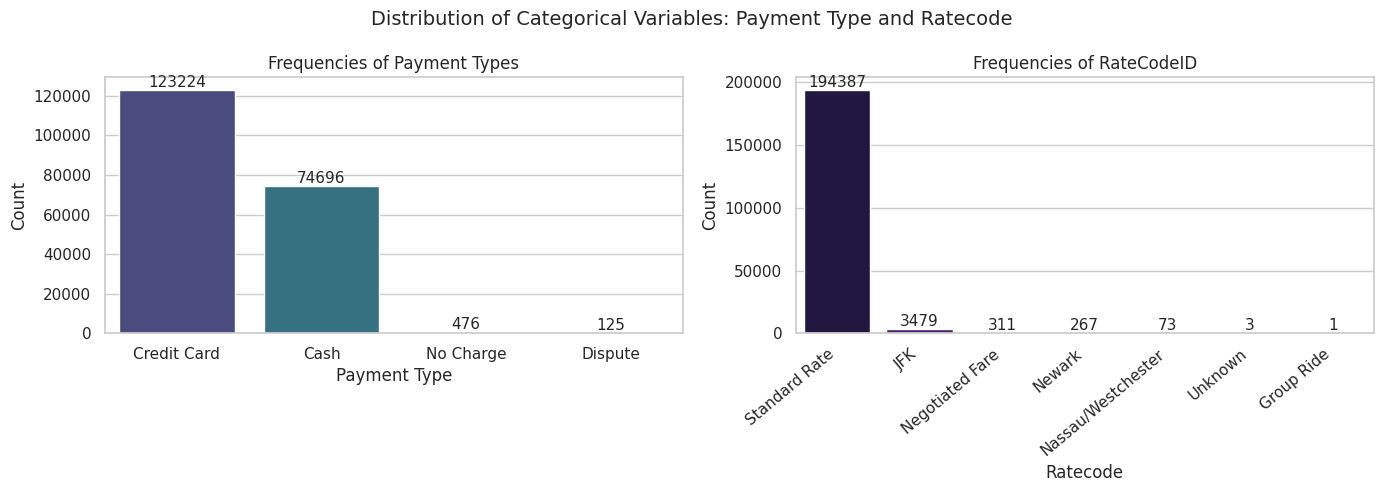

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Distribution of Categorical Variables: Payment Type and Ratecode", fontsize=14)

# ---- Payment Type ----
sns.countplot(
    x=df_clean['payment_type_label'],
    ax=axes[0],
    palette="viridis",
    order=df_clean['payment_type_label'].value_counts().index
)

axes[0].set_title("Frequencies of Payment Types")
axes[0].set_xlabel("Payment Type")
axes[0].set_ylabel("Count")

# Add numbers
add_labels(axes[0])

# ---- Ratecode ----
if rate_col is not None and rate_col in df_clean.columns:
    sns.countplot(
    x=df_clean["ratecode_label"],
    ax=axes[1],
    palette="magma",
    order=df_clean["ratecode_label"].value_counts().index
)
    axes[1].set_title(f"Frequencies of {rate_col}")
    axes[1].set_xlabel("Ratecode")
    axes[1].set_ylabel("Count")

    add_labels(axes[1])
    plt.setp(axes[1].get_xticklabels(), rotation=40, ha="right")

plt.tight_layout()
plt.show()

# Univariate Exploration
**trip_distance, fare_amount**

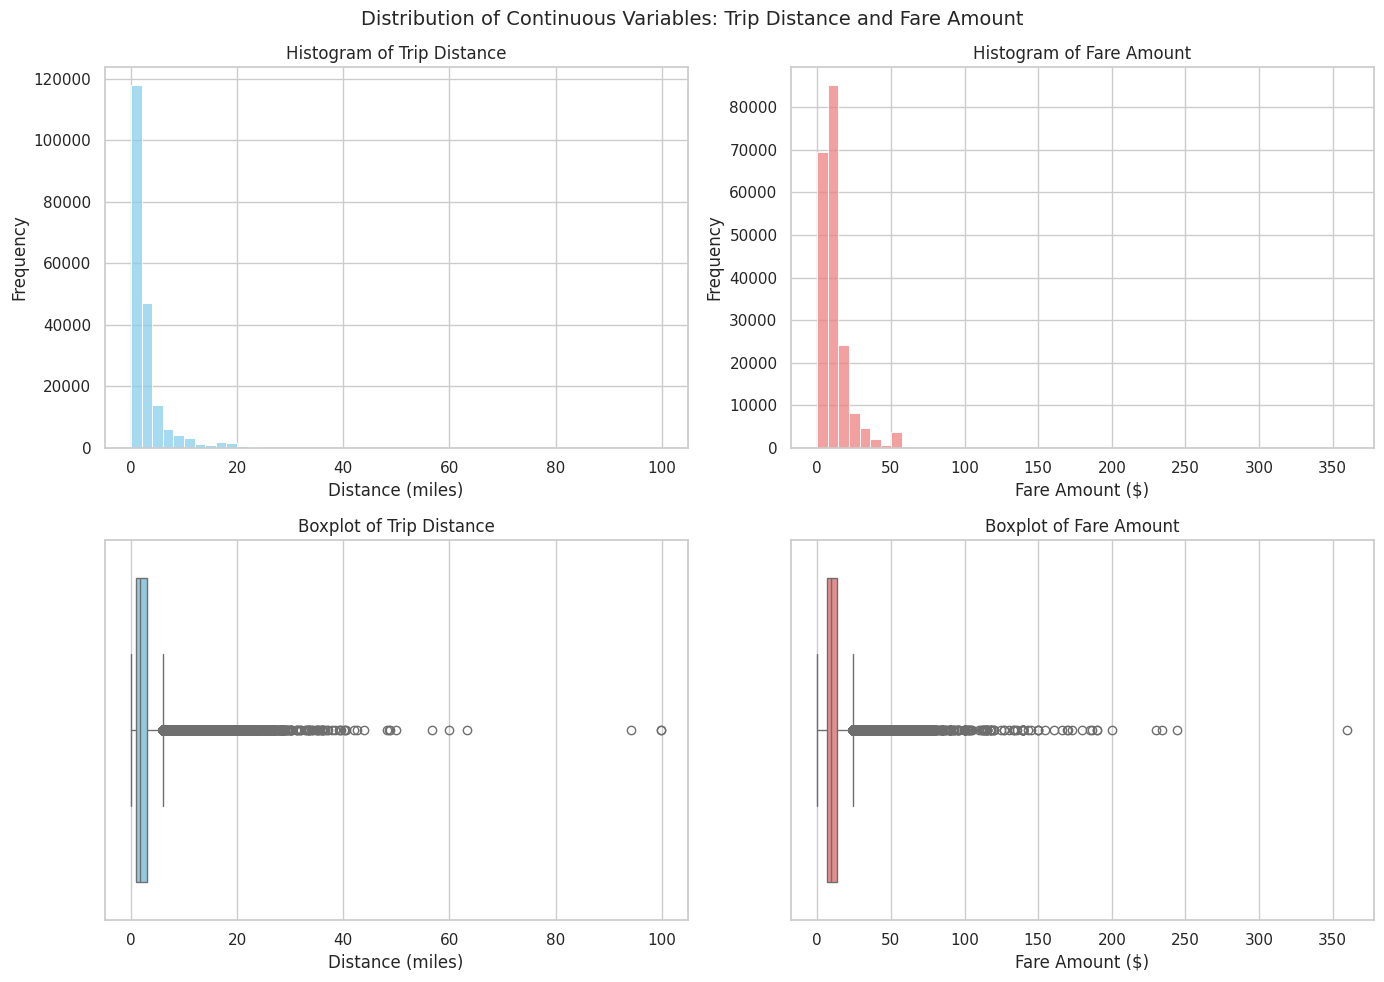

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set academic style for plots
sns.set_theme(style="whitegrid")

# Create a figure for Continuous Variables (Histograms & Boxplots)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Distribution of Continuous Variables: Trip Distance and Fare Amount", fontsize=14)

# 1. Histogram & Boxplot for trip_distance
sns.histplot(df_clean['trip_distance'], bins=50, kde=False, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title("Histogram of Trip Distance")
axes[0, 0].set_xlabel("Distance (miles)")
axes[0, 0].set_ylabel("Frequency")

sns.boxplot(x=df_clean['trip_distance'], ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title("Boxplot of Trip Distance")
axes[1, 0].set_xlabel("Distance (miles)")

# 2. Histogram & Boxplot for fare_amount
sns.histplot(df_clean['fare_amount'], bins=50, kde=False, ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title("Histogram of Fare Amount")
axes[0, 1].set_xlabel("Fare Amount ($)")
axes[0, 1].set_ylabel("Frequency")

sns.boxplot(x=df_clean['fare_amount'], ax=axes[1, 1], color='lightcoral')
axes[1, 1].set_title("Boxplot of Fare Amount")
axes[1, 1].set_xlabel("Fare Amount ($)")

plt.tight_layout()
plt.show()

#Group Comparisons
**Cash vs. Credit Card Fares**


--- 1. Cash vs. Card Inference ---


/tmp/ipython-input-2858686141.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Payment_Label', y=fare_col, data=df_inference, palette="Set2", showfliers=False)


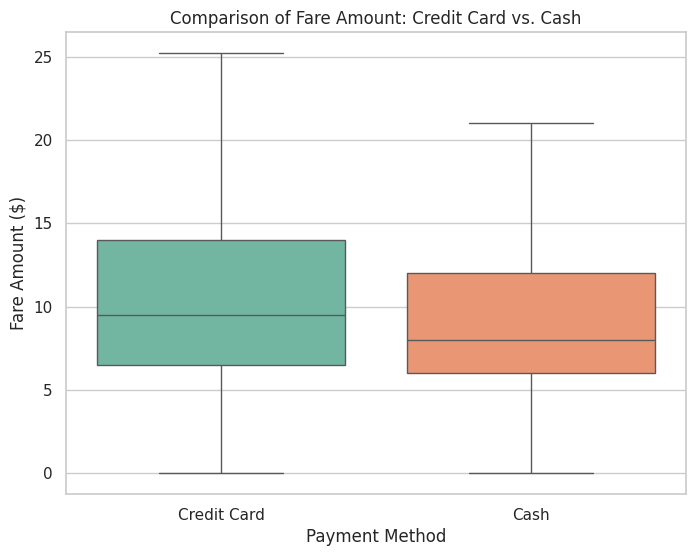

In [35]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# ---------------------------------------------------------
# 1. Prepare Payment Data
# ---------------------------------------------------------
pay_col = find_col(df_clean.columns, [r"payment_type", r"payment"], required=False)

if pay_col:
    # Filter to only Card (1) and Cash (2) for a clean binary comparison
    df_inference = df_clean[df_clean[pay_col].isin([1, 2])].copy()
    # Map to readable labels
    df_inference['Payment_Label'] = df_inference[pay_col].map({1: 'Credit Card', 2: 'Cash'})

    # ---------------------------------------------------------
    # 2. Visualization (Boxplot)
    # ---------------------------------------------------------
    print("\n--- 1. Cash vs. Card Inference ---")
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Payment_Label', y=fare_col, data=df_inference, palette="Set2", showfliers=False)
    plt.title("Comparison of Fare Amount: Credit Card vs. Cash")
    plt.ylabel("Fare Amount ($)")
    plt.xlabel("Payment Method")
    plt.show()

else:
    print("Warning: Payment column not found. Skipping Payment analysis.")

#Relationship Exploration
**Trip Distance vs Fare Amount**


--- 2. Relationship Exploration ---


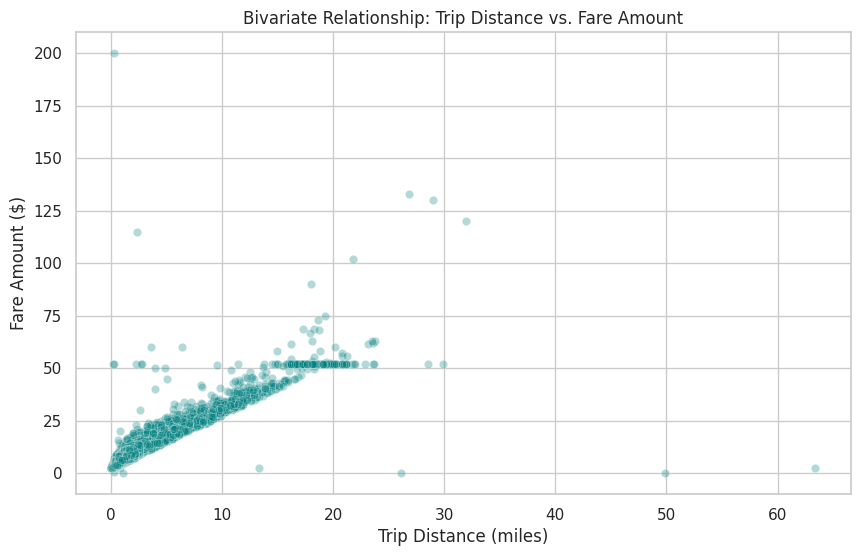

In [36]:
# ---------------------------------------------------------
# Relationship Exploration: Trip Distance vs Fare Amount
# ---------------------------------------------------------
print("\n--- 2. Relationship Exploration ---")

# Sample down for scatterplot clarity if dataset is huge (>10k rows)
# This prevents the plot from becoming a solid blob of color
if len(df_clean) > 10000:
    plot_data = df_clean.sample(10000, random_state=42)
else:
    plot_data = df_clean

# Create a single figure (removed the subplot logic)
plt.figure(figsize=(10, 6))

sns.scatterplot(x=dist_col, y=fare_col, data=plot_data, alpha=0.3, color='teal')

plt.title("Bivariate Relationship: Trip Distance vs. Fare Amount")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")

plt.show()

# 4. Descriptive Statistics

In [37]:
pay_col = find_col(df_clean.columns, [r"payment_type", r"payment"], required=False)

# 1. Payment Type Distribution
print("--- 7.1 Categorical Variable ---")
print("Payment Type Distribution:")

if pay_col and pay_col in df_clean.columns:
    # Map the numeric codes to readable labels just for this calculation
    # Standard TLC codes: 1=Credit card, 2=Cash, 3=No charge, 4=Dispute, 5=Unknown, 6=Voided
    payment_mapped = df_clean[pay_col].map({
        1: 'Credit Card', 2: 'Cash', 3: 'No Charge',
        4: 'Dispute', 5: 'Unknown', 6: 'Voided'
    }).fillna('Other') # Catch any undocumented numbers

    payment_counts = payment_mapped.value_counts()
    payment_pcts = payment_mapped.value_counts(normalize=True) * 100

    for method in payment_counts.index:
        count = payment_counts[method]
        pct = payment_pcts[method]
        print(f"{method}: {count:,} trips ({pct:.1f}%)")
else:
    print("Payment column not found in df_clean.")

# 2. Trip Distance
print("\n--- 7.2 Numerical Variables ---")
print("Trip Distance (Continuous)")
dist = df_clean[dist_col]
mean_dist = dist.mean()
med_dist = dist.median()
q1_dist = dist.quantile(0.25)
q3_dist = dist.quantile(0.75)
iqr_dist = q3_dist - q1_dist
fence_dist = q3_dist + 1.5 * iqr_dist

print(f"Mean = {mean_dist:.2f} miles, Median = {med_dist:.2f} miles")
print(f"Q1 = {q1_dist:.2f}, Q3 = {q3_dist:.2f}, IQR = {iqr_dist:.2f}")
print("Outlier detection (1.5 IQR rule):")
print(f"Upper fence = {q3_dist:.2f} + 1.5({iqr_dist:.2f}) = {fence_dist:.2f}")
print(f"Any trip distance > {fence_dist:.2f} miles is flagged as an outlier.")

--- 7.1 Categorical Variable ---
Payment Type Distribution:
Credit Card: 123,224 trips (62.1%)
Cash: 74,696 trips (37.6%)
No Charge: 476 trips (0.2%)
Dispute: 125 trips (0.1%)

--- 7.2 Numerical Variables ---
Trip Distance (Continuous)
Mean = 2.79 miles, Median = 1.69 miles
Q1 = 1.00, Q3 = 3.00, IQR = 2.00
Outlier detection (1.5 IQR rule):
Upper fence = 3.00 + 1.5(2.00) = 6.00
Any trip distance > 6.00 miles is flagged as an outlier.


In [38]:
# 3. Fare Amount
print("\nFare Amount (Continuous)")
fare = df_clean[fare_col]
mean_fare = fare.mean()
med_fare = fare.median()
q1_fare = fare.quantile(0.25)
q3_fare = fare.quantile(0.75)
iqr_fare = q3_fare - q1_fare
fence_fare = q3_fare + 1.5 * iqr_fare

print(f"Mean = ${mean_fare:.2f}, Median = ${med_fare:.2f}")
print(f"Q1 = ${q1_fare:.2f}, Q3 = ${q3_fare:.2f}, IQR = ${iqr_fare:.2f}")
print("Outlier detection (1.5 IQR rule):")
print(f"Upper fence = ${q3_fare:.2f} + 1.5(${iqr_fare:.2f}) = ${fence_fare:.2f}")
print(f"Any fare amount > ${fence_fare:.2f} is flagged as an outlier.")


Fare Amount (Continuous)
Mean = $11.85, Median = $9.00
Q1 = $6.50, Q3 = $13.50, IQR = $7.00
Outlier detection (1.5 IQR rule):
Upper fence = $13.50 + 1.5($7.00) = $24.00
Any fare amount > $24.00 is flagged as an outlier.


# 5. Statistical Inference

In [39]:
print("\n--- Basic Inference with Uncertainty (Bayes' Theorem) ---")
# Calculating the probability of a credit card payment given a high fare
high_fare_limit = 15.0

p_credit = (df_inference['Payment_Label'] == 'Credit Card').mean()
p_cash = (df_inference['Payment_Label'] == 'Cash').mean()

p_high_given_credit = (df_inference[df_inference['Payment_Label'] == 'Credit Card'][fare_col] > high_fare_limit).mean()
p_high_given_cash = (df_inference[df_inference['Payment_Label'] == 'Cash'][fare_col] > high_fare_limit).mean()

p_high_fare = (p_high_given_credit * p_credit) + (p_high_given_cash * p_cash)
p_credit_given_high = (p_high_given_credit * p_credit) / p_high_fare

print(f"P(Credit) = {p_credit:.3f}")
print(f"P(High Fare | Credit) = {p_high_given_credit:.3f}")
print(f"P(High Fare | Cash) = {p_high_given_cash:.3f}")
print(f"P(High Fare overall) = {p_high_fare:.3f}")
print(f"Bayes' Inference: P(Credit | High Fare) = {p_credit_given_high:.3f}")


--- Basic Inference with Uncertainty (Bayes' Theorem) ---
P(Credit) = 0.623
P(High Fare | Credit) = 0.214
P(High Fare | Cash) = 0.162
P(High Fare overall) = 0.194
Bayes' Inference: P(Credit | High Fare) = 0.685
